In [1]:
from individual_rules import *
from genetic_rules import SymbolicMaximizer
from data_rules import *
import graphviz
import pickle
import time

In [2]:
df, df_normalized = BTC_1d_Dataset(zscore=True)

In [3]:
df

,Volume,bb_bbm,bb_bbh,bb_bbl,psar,MACD,RSI,EMA11,EMA21,EMA130,EMA200,zscore,Entry_Price
0,17295.918653,10387.4700,11861.512259,8913.427741,9320.184000,288.042111,59.630737,10736.629381,10431.634248,10245.069018,9339.289258,0.663045,11454.00
1,15144.231063,10533.1750,11810.936738,9255.413262,9409.976640,327.683844,59.007457,10856.191151,10524.576589,10263.525979,9360.331156,0.640976,10716.48
2,29515.572363,10596.4995,11774.929509,9418.069491,9547.978042,296.174388,51.938843,10832.905959,10542.022354,10270.441308,9373.825174,0.456641,9910.00
3,50647.671080,10591.9950,11780.158111,9403.831889,11710.000000,203.777699,45.517703,10679.088299,10484.565776,10264.938387,9379.160247,0.255721,9271.64
4,41109.473226,10547.5780,11857.226873,9237.929127,11663.586200,78.141573,41.178164,10444.513583,10374.299797,10249.773526,9378.090394,0.095142,9227.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,310790.422710,22256.3760,24469.521417,20043.230583,23902.702616,1312.941437,73.817160,22878.608518,21912.918178,19744.112632,21238.736753,1.655810,23488.94
1796,364177.207510,22434.3225,24432.521654,20436.123346,22500.000000,1271.680741,70.327186,22980.330432,22056.192889,19801.285569,21261.126835,1.541532,23431.90
1797,332571.029040,22558.1715,24479.824794,20636.518206,22535.100000,1220.311696,69.499022,23055.592026,22181.257172,19856.714797,21282.726568,1.512096,23326.84
1798,166126.472950,22680.9385,24464.660042,20897.216958,22569.498000,1157.777754,67.912715,23100.800022,22285.401065,19909.693808,21303.066005,1.469709,22932.91


In [ ]:
df = pd.read_csv('Binance_BTCUSDT_d.csv')
df.drop(['Symbol', 'Unix', 'Volume USDT', 'tradecount'], axis=1, inplace=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df = df.sort_values('Date')
df.reset_index(drop=True, inplace=True)
# add month and year columns
df['Month'] = df['Date'].apply(lambda x: int(x.split('-')[1]))
df['Year'] = df['Date'].apply(lambda x: int(x.split('-')[0]))

import calendar
# transform the month number into a string
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(18, 10))
plt.plot(df['Date'][:-364], df['Close'][:-364], label='Training Data')
plt.plot(df['Date'][-365:], df['Close'][-365:], label='Test Data' ,color='tomato')
plt.xticks(df['Date'][::90], df['Month'][::90], rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.title('Bitcoin Historical Chart', fontsize=25)
plt.xlabel('Date (2017-2023)', fontsize=22)
plt.ylabel('Close Price ($)', fontsize=22)
plt.legend(loc='upper left', fontsize=18)
plt.savefig('BTC_Historical_Chart.png')
plt.show()

In [17]:
prices = np.array(df['Entry_Price'][:-365])
prices_test = np.array(df['Entry_Price'][-365:])

dataset = df.drop(['Entry_Price'], axis=1)

test = np.array(dataset[-365:])
dataset = np.array(dataset[:-365])

indicators = df.columns

rules = default_rules_set()

In [5]:
path = 'models/BTC_500p_500g_rules_zscore_elitism.pkl'
with open(path, 'rb') as f:
    gp = pickle.load(f)

In [6]:
gp._program.raw_fitness_

1685.9441285359624

In [7]:
length_buy_ops = len(gp._program.buy_ops)
len(gp._program.buy_ops), len(gp._program.sell_ops)

(10, 10)

In [8]:
gp._program

if cross_above_buy(bb_bbl, EMA200) -> buy
if cross_below_buy(psar, EMA130) -> buy
if lss_buy(EMA130, EMA21) -> buy
if cross_above_buy(EMA21, bb_bbm) -> buy
if cross_below_sell(EMA130, EMA11) -> sell

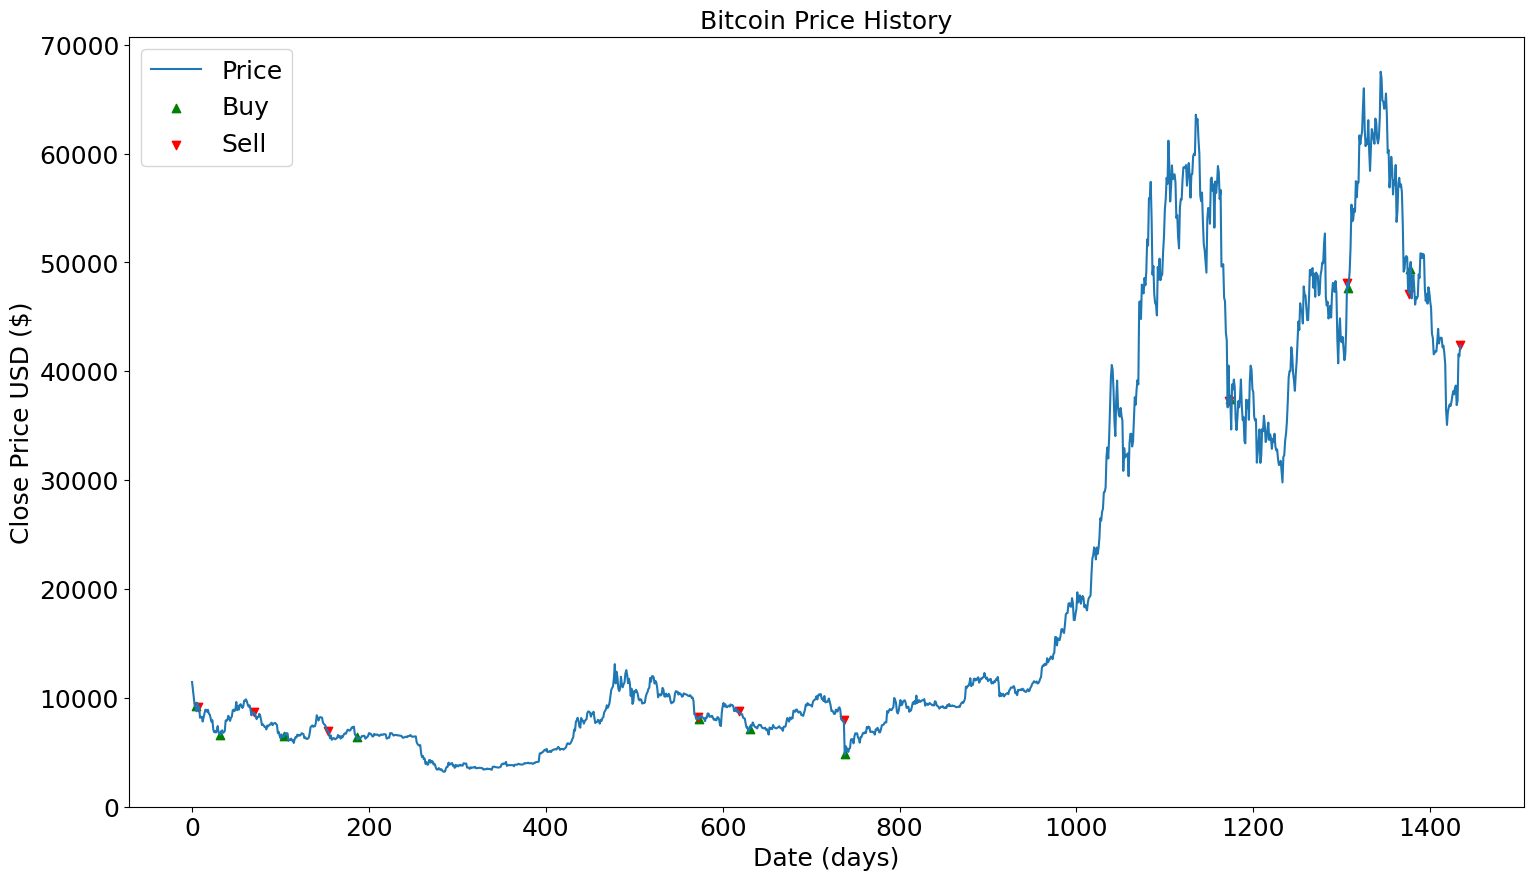

In [9]:
plot_results(prices, gp._program.buy_ops, gp._program.sell_ops, title="Train Operations", save=True, name="BTC_train.png")

In [26]:
gp.predict(test, rules, prices_test, 100)

-100

In [46]:
# calculate the profit from buy and sell operations
def calculate_profit(buy_ops, sell_ops, data, init_investment=100):
    investment = init_investment
    for i in range(len(buy_ops)):
        buy_price = data[buy_ops[i]]
        sell_price = data[sell_ops[i]]
        print('Buy at: ', buy_price, '. Sell at: ', sell_price, '. Capital: ', investment, '. Profit: ', investment/buy_price*sell_price - investment)
        investment = investment / buy_price * sell_price
    return investment

In [47]:
investment = calculate_profit(gp._program.buy_ops[length_buy_ops:], gp._program.sell_ops[length_buy_ops:], prices_test)
investment

Buy at:  37008.16 . Sell at:  40074.94 . Capital:  100 . Profit:  8.286767026515236
Buy at:  34038.4 . Sell at:  22762.52 . Capital:  108.28676702651524 . Profit:  -35.87209124338813


72.41467578312711

In [ ]:
# BTC_500p_500g_close - Fitness: 7525.80 - Test_fitness: 60.93
# BTC_500p_200g_close_elitism - Fitness: 17266.13 - Test_fitness: 60.64 
# BTC_500p_500g_zscore - Fitness: 4560.57 - Test_fitness: 85.83
# BTC_500p_200g_zscore_elitism - Fitness: 1685.94 - Test_fitness: 72.41

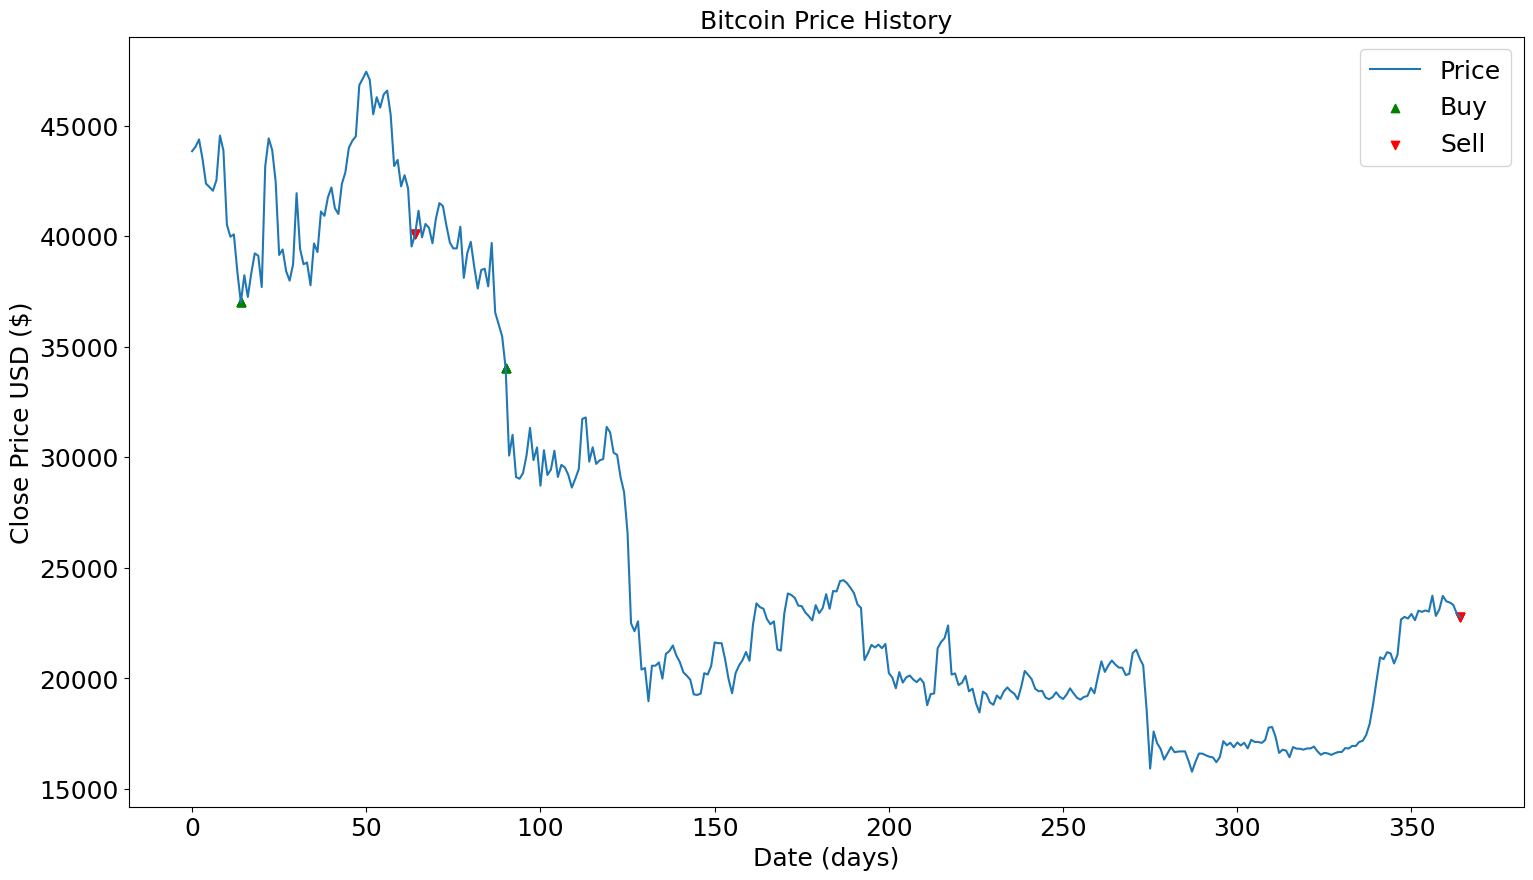

In [27]:
plot_results(prices_test, gp._program.buy_ops[length_buy_ops:], gp._program.sell_ops[length_buy_ops:], title="Test Operations", save=True, name="BTC_test")

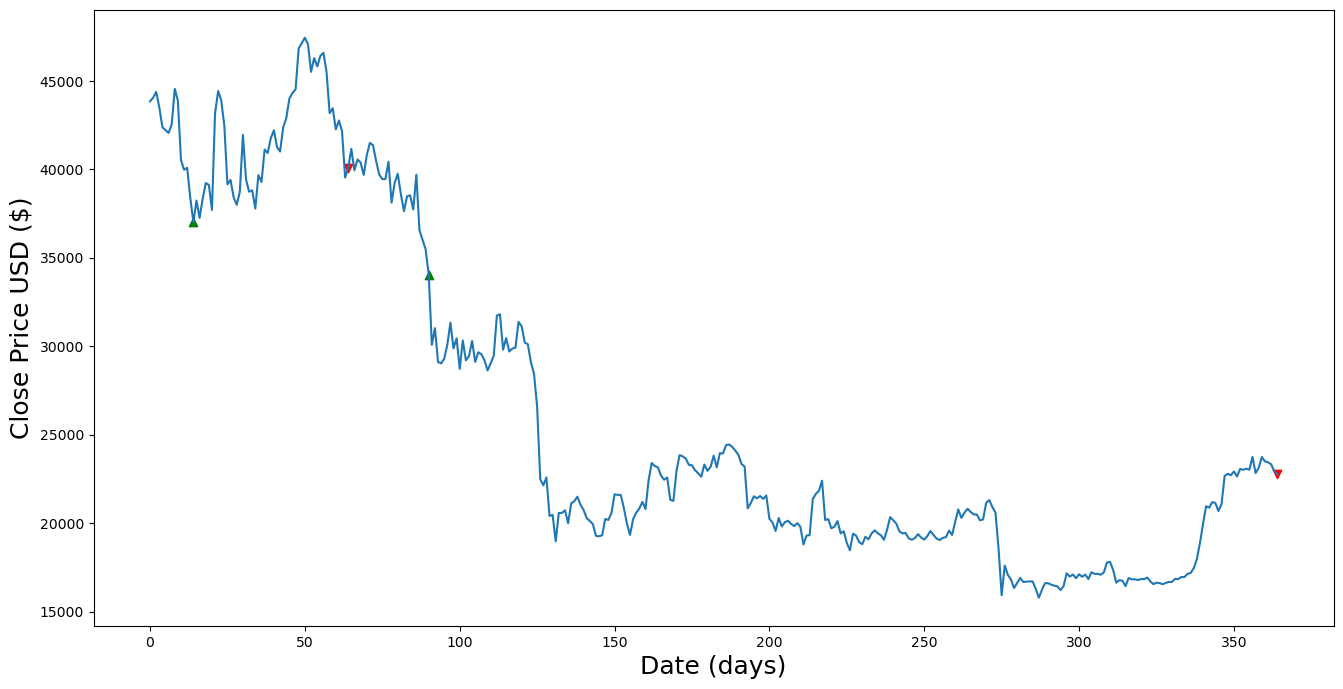

In [49]:
plt.figure(figsize=(16,8))
plt.plot(prices_test, label='Price')
plt.xlabel('Date (days)', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
# plot a buy signal
plt.scatter(gp._program.buy_ops[length_buy_ops:], prices_test[gp._program.buy_ops[length_buy_ops:]], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(gp._program.sell_ops[length_buy_ops:], prices_test[gp._program.sell_ops[length_buy_ops:]], color='red', label='Sell', marker='v', alpha=1)
plt.show()